# Flows Above Normal

## Post-crisis analysis

In this worked example we assume the role of an analyst working in the aftermath of a significant crisis in Nepal. Our aim is to use FlowKit to investigate which administrative regions people have been displaced from/to during the crisis, following the methodology used in [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4779046/).

The Jupyter notebook for this worked example can be downloaded [here](https://github.com/Flowminder/FlowKit/raw/master/docs/source/analyst/worked_examples/flows-above-normal.ipynb), or can be run using the [quick start setup](../../install.md#quickinstall).

### Introduction

We want to investigate changes in people's home locations caused by the crisis. To do this we will calculate an origin-destination matrix, containing the number of subscribers who lived in region A during a 'benchmark' period before the crisis, but had moved to region B during a 'focal' period after the start of the crisis, for each pair of regions A and B. We call this the 'flows' from the benchmark period to the focal period.

Some of these movements would have been made under normal circumstances, and were not caused by the crisis. To separate the crisis-driven movements from normal mobility patterns, we will also calculate a second origin-destination matrix, containing the flows from the same benchmark period to a 'comparison' period shortly _before_ the crisis began. We can then subtract these 'normal' flows from the 'crisis' flows to get the _flows above normal_, which we assume to have been caused by the crisis. The diagram below shows the two flows that we will calculate.

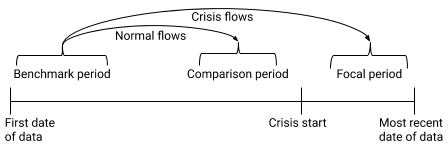

We will finish by using the `mapboxgl` library to display the total flows above normal in or out of each region on an interactive map, which will look like this:

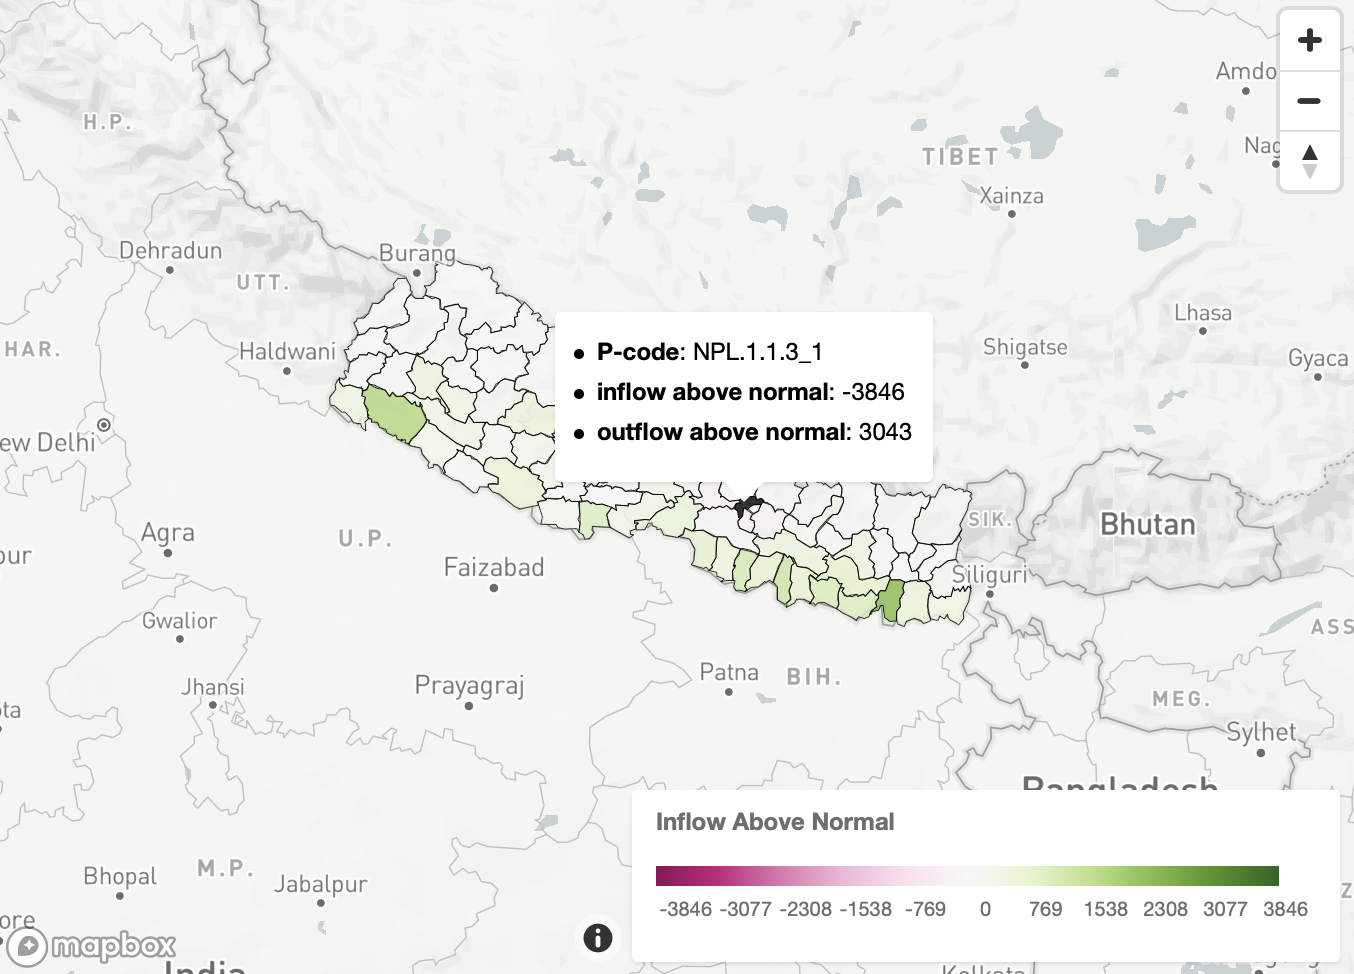

### Load FlowClient and connect to FlowAPI

We start by importing FlowClient. We also import [geopandas](http://geopandas.org/) and [mapboxgl](https://mapbox-mapboxgl-jupyter.readthedocs-hosted.com/en/latest/), which we will use later to to visualise the data.

In [ ]:
import flowclient as fc
import os
import numpy as np
import geopandas as gpd
import mapboxgl
from mapboxgl.utils import create_color_stops

%matplotlib inline

We must next [generate a FlowAPI access token](../index.md#flowauth) using FlowAuth. If you are running this notebook using the [quick start setup](../../install.md#quickinstall), generating a token requires the following steps:

1. Visit the FlowAuth login page at [http://localhost:9091](http://localhost:9091/).
2. Log in with username `TEST_USER` and password `DUMMY_PASSWORD`.
3. Under "My Servers", select `TEST_SERVER`.
4. Click the `+` button to create a new token.
5. Give the new token a name, and click `SAVE`.
6. Copy the token string using the `COPY` button.
7. Paste the token in this notebook as `TOKEN`.

The steps are the same in a production setup, but the FlowAuth URL, login details and server name will differ.

Tokens are only valid for a fixed time, so once a token has expired you will need to create a new one. 

Once we have a token, we can start a connection to the FlowAPI system.  If you are connecting to FlowAPI over https and the system administrator has provided you with an SSL certificate file, you should provide the path to this file as the `ssl_certificate` argument to`flowclient.connect()` (in this example, you can set the path in the environment variable `SSL_CERTIFICATE_FILE`). If you are connecting over http, this argument is not required.

In [ ]:
conn = fc.connect(
    url=os.getenv(
        "FLOWAPI_URL", "http://localhost:9090"
    ),  # This is the URL for the interface flowclient uses to communicate with the FlowKit server
    token=TOKEN,  # Replace TOKEN with the token copied from FlowAuth
    ssl_certificate=os.getenv(
        "SSL_CERTIFICATE_FILE"
    ),  # Path to the SSL certificate file (required if FlowAPI uses an https connection)
)

### Calculate origin-destination matrices

#### 1. Create query specifications

We first need to choose the three time periods (benchmark, comparison and focal) between which we will calculate flows. The simulated crisis in our fake dataset begins on 10th February 2016, so both the benchmark and comparison periods should fall entirely before this date, and the focal period should be after this date.

We can use the flowclient `get_available_dates` function to check which dates have data available in FlowKit. We need to provide the connection we have just created as the 'connection' argument - flowclient uses this to communicate with the FlowKit server.

In [ ]:
fc.get_available_dates(connection=conn)

We can see that we have data for all days from 1st January to 29th February 2016, for each of three event types: 'calls', 'sms' and 'mds' (mobile data sessions). Let's define our three reference periods as:

- 'benchmark' period: the first 21 days of available data,  
- 'comparison' period: the last 14 days before the crisis begins,  
- 'focal' period: the first 14 days from the start of the crisis.  

To count changes in subscribers' home locations between these periods, we need to define what we mean by 'home' locations. Here we will calculate 'modal locations'; a subscriber's modal location is calculated by assigning them a single location each day, and then finding their most common daily location over the period of interest. FlowKit provides two methods for determining the daily locations: 'last' (i.e. the location from which they made the last call of the day) or 'most-common' (i.e. the location from which they most commonly made/received calls during the day). Here we will use the 'last' method.

We can use the flowclient `modal_location_from_dates` function to create a modal location query specification for the benchmark period. (A query specification is a dictionary containing the parameters of a FlowKit query). This takes four arguments:

- `start_date`: the first date in the benchmark period
- `end_date`: the day _after_ the last date in the benchmark period
- `method`: the method to use for calculating daily locations ("last" or "most-common")
- `aggregation_unit`: the spatial aggregation level (here we will use "admin3", to use administrative level 3 regions as the subscriber locations)

**Note:** when specifying FlowKit queries, the end date is _not_ included in the interval.

In [ ]:
# Create modal location query specification for benchmark period
# (Note: this is not the query result, just the parameters we will use to run the query)

benchmark_locations_spec = fc.modal_location_from_dates_spec(
    start_date="2016-01-01",  # First date in the period
    end_date="2016-01-22",  # Day after the last date in the period
    method="last",  # Use last event of the day to define daily locations
    aggregation_unit="admin3",  # Use administrative level 3 regions as the locations
)

We repeat this process to create two more modal location query specifications, for the comparison and focal periods:

In [ ]:
# Create modal location query specifications for comparison and focal periods
# (Note: these are not the query results, just the parameters we will use to run the queries)

comparison_locations_spec = fc.modal_location_from_dates_spec(
    start_date="2016-01-27",  # First date in the period
    end_date="2016-02-10",  # Day after the last date in the period
    method="last",  # Use last event of the day to define daily locations
    aggregation_unit="admin3",  # Use administrative level 3 regions as the locations
)

focal_locations_spec = fc.modal_location_from_dates_spec(
    start_date="2016-02-10",  # First date in the period
    end_date="2016-02-24",  # Day after the last date in the period
    method="last",  # Use last event of the day to define daily locations
    aggregation_unit="admin3",  # Use administrative level 3 regions as the locations
)

Let's put these three query specifications into a dictionary, so we can more easily loop over them later (when running the queries and getting results):

In [ ]:
# Put the three modal location query specifications in a dictionary
home_locations_specs = {
    "benchmark": benchmark_locations_spec,
    "comparison": comparison_locations_spec,
    "focal": focal_locations_spec,
}

Next, we use the `flows` function to create specifications for the two flows queries. Each flows query takes two modal location query specifications as parameters `from_location` and `to_location`, and an `aggregation_unit` parameter that must match the aggregation units of the two location queries.

In [ ]:
# Create query specifications for the two flows

normal_flows_spec = fc.aggregates.flows_spec(
    from_location=home_locations_specs[
        "benchmark"
    ],  # 'from' location is the benchmark modal locations
    to_location=home_locations_specs[
        "comparison"
    ],  # 'to' location is the comparison modal locations
)

crisis_flows_spec = fc.aggregates.flows_spec(
    from_location=home_locations_specs[
        "benchmark"
    ],  # 'from' location is the benchmark modal locations
    to_location=home_locations_specs[
        "focal"
    ],  # 'to' location is the focal modal locations
)

#### 2. Run the queries

Modal location queries return subscriber-level results, which cannot be accessed directly through FlowAPI. We can create spatially-aggregated query specifications by passing each modal location query specification to the `spatial_aggregate` function, and pass these query specifications to the `run_query` function to start running them.

Because some FlowKit queries may take a long time to run, the `run_query` function doesn't return the result of the query. Instead, it returns a query ID that can be used to check the status of the query run, and get the result when it is finished.

In [ ]:
# Run spatial aggregates of the home locations queries

home_locations_ids = {
    period: fc.run_query(
        connection=conn,
        query_spec=fc.aggregates.spatial_aggregate_spec(
            locations=query_spec
        ),  # Wrap the query spec in a spatial aggregate query, so that we are allowed to get the result
    )
    for period, query_spec in home_locations_specs.items()  # Loop over the three query specifications and run them all
}

home_locations_ids

Unlike the `modal_location` queries, `flows` queries return aggregated results, so we can directly run the two `flows` queries.

In [ ]:
# Run the flows queries
normal_flows_id = fc.run_query(connection=conn, query_spec=normal_flows_spec)
crisis_flows_id = fc.run_query(connection=conn, query_spec=crisis_flows_spec)

print(normal_flows_id, crisis_flows_id)

We can periodically check the status of the queries using the `get_status` function.

In [ ]:
# Get status of flows queries
for flows_id in [normal_flows_id, crisis_flows_id]:
    print(fc.get_status(connection=conn, query_id=flows_id))

### Visualise the distributions of locations

The flows queries may take some time to calculate. While we wait, let's visualise the results of the spatially-aggregated home locations queries, to see the distributions of home locations during the three periods.

#### 1. Download geography data

If we want to display our query results on a map, we will need to combine them with geography data for the level 3 administrative regions. We can download the shapes of the spatial regions as a GeoJSON dictionary using the `get_geography` function.

In [ ]:
# Download geography data as GeoJSON
# (aggregation_unit here needs to match the one we used for the modal locations and flows query specifications)
regions = fc.get_geography(connection=conn, aggregation_unit="admin3")

To help with joining the geography data to query results, it is helpful to load the GeoJSON into a geopandas GeoDataFrame. The dataframe has three columns:

- 'pcod': the [P-code](https://sites.google.com/site/ochaimwiki/geodata-preparation-manual/p-code-guidelines) that identifies each admin3 region. We set this as the index.  
- 'geometry': the polygons that describe the shapes of the regions.  
- 'centroid': a point location in the centre of each region. We won't use the centroid data in this example.  

In [ ]:
# Create a geopandas GeoDataFrame from the GeoJSON
regions_geodataframe = gpd.GeoDataFrame.from_features(regions).set_index("pcod")

regions_geodataframe.head()

The GeoDataFrame has a 'plot' method that allows us to quickly see the shapes of the regions:

In [ ]:
regions_geodataframe.plot();

#### 2. Get query results
Hopefully our home locations queries have finished running by now. We can use the `get_result` function to get the results of the spatial aggregate queries as pandas DataFrames.

In [ ]:
# Get results for the spatially-aggregated home locations queries
home_locations_results = {
    period: fc.get_result(
        connection=conn,
        query_spec=fc.aggregates.spatial_aggregate_spec(locations=query_spec),
    )
    for period, query_spec in home_locations_specs.items()
}

Let's look at the "benchmark" dataframe. It has two columns:

- 'pcod' is the P-code that identifies the region. We-ll use this to join to the geography data.  
- 'value' is the number of subscribers whose modal location is in each region.

In [ ]:
home_locations_results["benchmark"].head()

#### 3. Visualise the results

Now that we have the home locations query results and geography data for the spatial regions, we can use these to create a choropleth map. In this example we will use the `Mapbox GL` library for the visualisation, which requires us to first join the datasets.

Since we have all datasets in pandas/geopandas dataframes, we can use the 'join' method to join them, using the 'pcod' column.

In [ ]:
# First, rename the 'value' column in each of the result dataframes, so they all have different names
for period in home_locations_results.keys():
    home_locations_results[period] = home_locations_results[period].rename(
        columns={"value": f"Total ({period} period)"}
    )

# Join the result dataframes to the geography data, using the 'pcod' column
# (we provide a list of dataframes here, to join them all at once)
home_locations_geodataframe = regions_geodataframe.join(
    [result.set_index("pcod") for result in home_locations_results.values()],
    how="left",
)

home_locations_geodataframe.head()

There are some entries with missing values in the joined dataframe. This is because FlowKit redacts any values representing fewer than 15 subscribers, to protect those subscribers' privacy, so we are missing the results for regions where fewer than 15 people have their modal locations. We can assume that there are 0 subscribers in these regions, so let's fill the missing values with 0.

In [ ]:
# Use pandas 'fillna' method to fill missing values with 0
home_locations_geodataframe = home_locations_geodataframe.fillna(0)

We will be able to hover over the map and see the values in each column, so let's drop columns we don't need and ensure the remaining columns have sensible names.

In [ ]:
# Drop the 'centroid' column, since we're not using it
home_locations_geodataframe = home_locations_geodataframe.drop(columns="centroid")
# Rename the 'pcod' column to 'P-code'
home_locations_geodataframe = home_locations_geodataframe.reset_index().rename(
    columns={"pcod": "P-code"}
)

home_locations_geodataframe.head()

Now we are ready to create a choropleth showing the distribution of modal locations, using `mapboxgl.ChoroplethViz`.

**Note:** Mapbox requires an [access token](https://www.mapbox.com/account/), which should be set as the environment variable `MAPBOX_ACCESS_TOKEN`. Note that this is only required for producing the Mapbox visualisations, which is completely separate from FlowKit.

In [ ]:
period_to_show = "benchmark"  # Change this to "comparison" or "focal" to show results for the other periods

mapbox_token = os.environ["MAPBOX_ACCESS_TOKEN"]

# Colour scale for legend
max_total = max(
    [
        home_locations_geodataframe[f"Total ({period} period)"].max()
        for period in home_locations_specs.keys()
    ]
)
color_stops = create_color_stops(np.linspace(0, max_total, 9), colors="YlGn")

# Create a map using mapboxgl.ChoroplethViz
home_locations_viz = mapboxgl.ChoroplethViz(
    home_locations_geodataframe.__geo_interface__,
    access_token=mapbox_token,
    color_property=f"Total ({period_to_show} period)",
    color_stops=color_stops,
    opacity=0.8,
    line_color="black",
    line_width=0.5,
    legend_gradient=True,
    legend_layout="horizontal",
    legend_text_numeric_precision=0,
    below_layer="waterway-label",
    center=(84.1, 28.4),
    zoom=5.5,
)

# Show the visualisation
home_locations_viz.show()

We can see there are five regions in the North-West which contain subscribers' modal locations during the benchmark and comparison periods, but 0 subscribers have their home locations in these regions during the focal period, indicating that these are the regions directly affected by the crisis.

### Calculate flows above normal

Once the flows queries have finished running, we can obtain the results for the flows. We can either use the `get_result` function, as we did earlier for the spatial aggregate queries, or we can use `get_result_by_query_id`. This is the same as `get_result`, except that it takes the query ID as a parameter instead of the query specification.

In [ ]:
# Get the results of the flows queries
normal_flows_result = fc.get_result_by_query_id(
    connection=conn, query_id=normal_flows_id
)
crisis_flows_result = fc.get_result_by_query_id(
    connection=conn, query_id=crisis_flows_id
)

Let's have a look at the results of the 'crisis' flows query (flows from benchmark period to focal period).
This has three columns:

- 'pcod_from' is the P-code of the 'from' location  
- 'pcod_to' is the P-code of the 'to' location  
- 'value' is the number of subscribers whose modal location during the benchmark period was the 'from' location, and modal location during the focal period was the 'to' location (i.e. the number of subscribers who moved from one region to the other between the benchmark and focal periods)  

In [ ]:
crisis_flows_result.head()

The result of the crisis flows query tells us about subscribers' movements from the benchmark period before the crisis to the focal period after the crisis begins. These movements will include ordinary mobility patterns which would have occurred even if the crisis had not happened. The 'normal' flows query captures movements between two periods before the crisis began, so does not include any movements caused by the crisis. We can subtract the "normal" flow from the "crisis" flow to estimate the flows driven directly by the crisis (or "flows above normal").

In [ ]:
# We set the 'pcod_from' and 'pcod_to' columns as the index for both flows results,
# so that when we subtract one result from the other we are subtracting results for the same pairs of regions.
crisis_flows_result = crisis_flows_result.set_index(["pcod_from", "pcod_to"])
normal_flows_result = normal_flows_result.set_index(["pcod_from", "pcod_to"])

# The 'subtract' method lets us set fill_value=0 to fill missing values
flows_above_normal = crisis_flows_result.subtract(normal_flows_result, fill_value=0)

# We can reset the index using 'reset_index', so that 'pcod_from' and 'pcod_to' are normal columns again
flows_above_normal = flows_above_normal.reset_index()

# A negative value here indicates that fewer people than normal moved between that pair of regions during the crisis.
flows_above_normal.head()

### Inflows and outflows

In order to visualise the flows above normal on a map, as we did for the home locations, it is convenient to aggregate them so that we have a single result per admin3 region. We can do this by calculating the inflows above normal (total flows above normal into a region from all other regions) and outflows above normal (total flows above normal out of a region into all other regions). By doing so, we lose information about the individual flows between pairs of regions, but we get a result that is easier to visualise.

In [ ]:
# Select only the rows where 'pcod_from' and 'pcod_to' are different
flows_between_different_regions = flows_above_normal[
    flows_above_normal["pcod_from"] != flows_above_normal["pcod_to"]
]

# Group by 'pcod_to' and sum, to get the total inflows-above-normal
inflows_above_normal = flows_between_different_regions.groupby("pcod_to").sum()
# Group by 'pcod_from' and sum, to get the total outflows-above-normal
outflows_above_normal = flows_between_different_regions.groupby("pcod_from").sum()

As with the modal locations results, we need to combine these results with the geography data to create choropleth maps using mapboxgl. The geography data are the same as we used when visualising the home locations results, so we can re-use the `regions_geodataframe` we created earlier.

In [ ]:
# Before joining to the geography data, we change the names of the 'value' columns
inflows_above_normal = inflows_above_normal.rename(
    columns={"value": "inflow above normal"}
)
outflows_above_normal = outflows_above_normal.rename(
    columns={"value": "outflow above normal"}
)

# Join geography to inflows and outflows
in_out_flows_geodataframe = regions_geodataframe.join(
    [inflows_above_normal, outflows_above_normal], how="left"
)

# Fill missing values with 0
in_out_flows_geodataframe = in_out_flows_geodataframe.fillna(0)
# We're not using the 'centroid' column, so let's drop it
in_out_flows_geodataframe = in_out_flows_geodataframe.drop(columns="centroid")
# Rename the 'pcod' column to 'P-code'
in_out_flows_geodataframe = in_out_flows_geodataframe.reset_index().rename(
    columns={"pcod": "P-code"}
)

in_out_flows_geodataframe.head()

Finally, we can show the inflows or outflows on a choropleth map, using `mapboxgl.ChoroplethViz`.

In [ ]:
direction_to_show = "in"  # Change this to "out" to show the outflows

mapbox_token = os.environ["MAPBOX_ACCESS_TOKEN"]

# Colour scale for legend
max_count = max(
    [
        in_out_flows_geodataframe[f"{direction}flow above normal"].abs().max()
        for direction in ["in", "out"]
    ]
)
color_stops = create_color_stops(np.linspace(-max_count, max_count, 11), colors="PiYG")

# Create a map using mapboxgl.ChoroplethViz
flows_viz = mapboxgl.ChoroplethViz(
    in_out_flows_geodataframe.__geo_interface__,
    access_token=mapbox_token,
    color_property=f"{direction_to_show}flow above normal",
    color_stops=color_stops,
    opacity=0.8,
    line_color="black",
    line_width=0.5,
    legend_gradient=True,
    legend_layout="horizontal",
    legend_text_numeric_precision=0,
    below_layer="waterway-label",
    center=(84.1, 28.4),
    zoom=5.5,
)

# Show the visualisation
flows_viz.show()

We can see that there are 5 regions for which the inflows above normal are negative (pink), and the rest of the country has predominantly positive values (green). This indicates that fewer people than normal are moving into the areas affected by the crisis, and areas not directly affected are seeing more people entering than usual (presumably people who have been displaced by the crisis).